# MNIST Next-Number Image Mapping with a Densely Connected NN (PyTorch Lightning)
PyTorch Lightning is a much more involved wrapper than HuggingFace Accelerate. It aims to remove most boilerplate code from Base PyTorch -- for example, entirely removing the training loop -- and encapsulates more functionality within Lightning Module classes.

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import lightning as pl
from lightning.pytorch.callbacks import ModelCheckpoint, TQDMProgressBar

from netCDF4 import Dataset as nc_Dataset
from torch.utils.data import DataLoader

import xarray as xr
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

## Boilerplate Classes <span style="color: red;">(substantial differences)</span>
PyTorch Lightning shifts the boilerplate from main() to a couple module classes.

### Dataset Class
With PyTorch Lightning, ANY iterable can be used for the train/test splits. However, writing a functional torch Dataset will save you headaches down the line. For this reason, we keep the same Dataset as before. In fact, we can go one step further in the PyTorch Lightning framework and write a class which inherits from lightning.LightningDataModule to fully encapsulate the data loading functionality.

### Model Class
Inherits from lightning.LightningModule. This class encapsulates your model architecture and training loop behavior. PyTorch Lightning modifies training loop behavior via "hooks" (a full list of which can be found [here](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.core.hooks.ModelHooks.html)). Basically any custom behavior you would normally describe during the training loop in base PyTorch must instead be called in the relevant hook within this class.

The functions I have defined in this class are as follows. 100% necessary functions have an *:
- **\_\_init\_\_(self, \*args, \*\*hyperparameter_kwargs)\*** : In addition to instantiating your model's architectural components, you also instantiate loss function and optimizer hyperparameters.
- **forward(self, x, \*args)\*** : Describes how an input tensor, x, moves through your model. Since most modules don't mutate x, x is reassigned after each operation. It goes without saying that the final tensor returned by this method should match the dimensions of your target.
- **configure_optimizers(self)\*** : Defines and returns the optimizer used during training. This function can also include a learning rate scheduler, in which case the function would return \[optimizer], \[lr_scheduler].
- **training_step(self, train_batch, batch_idx)\*** : Defines how to compute loss during the training step and can encapsulate any additional logging behavior after each training step.
- **validation_step(self, val_batch, batch_idx)** : Defines behavior when computing loss on the validation dataset (in our case, just the test data). I describe two methods for printing out model performance. The first is to use the built-in logger (basically just a dict) which automatically aggregates the loss with a mean across all batches. The second is to manually aggregate using the returned losses from every batch.
- **on_validation_epoch_end(self, outputs)** : Example of a module hook. Describes behavior at the end of a training epoch after the last validation step in that epoch. The outputs are a list of returned losses from **validation_step** calls.

In [2]:
class MNISTNextDigitDataset(Dataset):
    """
    Assumes you've generated nc files as described in create_nc_MNIST.py and have mappings from MNIST_num2num_mapping.py.
    """
    def __init__(self, is_train = False):
        """
        :param is_train: bool - describes whether to load training or testing dataset
        """

        #get paths
        if is_train:
            data_save_path = os.path.join(os.getcwd(), "data", "MNIST", "nc_versions", "MNIST_training.nc")
            indices_save_path = os.path.join(os.getcwd(), "data", "MNIST", "num2num_indices", "train_indices.csv")
        else:
            data_save_path = os.path.join(os.getcwd(), "data", "MNIST", "nc_versions", "MNIST_testing.nc")
            indices_save_path = os.path.join(os.getcwd(), "data", "MNIST", "num2num_indices", "test_indices.csv")

        #open netCDF4 Dataset of MNIST
        self.nc_dataset = nc_Dataset(data_save_path)

        #read mapping indices from CSV
        self.predictor_indices, self.target_indices = self._read_mapping_indices_from_csv(indices_save_path)
        assert len(self.predictor_indices) == len(self.target_indices), "Predictor indices array should be of the same length as the target indices array"
        
    def __len__(self):
        return len(self.predictor_indices)
        
    def __getitem__(self, idx):

        #get sample index for predictor and target
        p_idx = self.predictor_indices[idx]
        t_idx = self.target_indices[idx]

        #extract images from nc_dataset
        predictor = self.nc_dataset["image"][p_idx,:,:].data[np.newaxis,:,:] #get image and add channel dimension
        target = self.nc_dataset["image"][t_idx,:,:].data[np.newaxis,:,:]
        
        return (predictor), (target) #important to return tuple of tuples! Allows nice X, y unpacking and allows PyTorch to do the tensor casting itself
    
    @staticmethod
    def _read_mapping_indices_from_csv(csv_path):
        df = pd.read_csv(csv_path)
        predictor_indices = df['predictor'].values 
        target_indices = df['target'].values
        return predictor_indices, target_indices

#handles data loading
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=64):
        super().__init__()
        self.batch_size = batch_size
        self.train_ds = MNISTNextDigitDataset(is_train=True)
        self.test_ds = MNISTNextDigitDataset(is_train=False)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, shuffle=True)

#super simple neural net
class DenseNeuralNetwork(pl.LightningModule):
    def __init__(self, learning_rate = -999.):
        super().__init__()

        #set hyperparameters
        self.learning_rate = learning_rate
        self.loss_function = nn.MSELoss()
        
        #define components of your network
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512), #hidden layer 1; img_dim -> 512 neurons
            nn.ReLU(), #activation
            nn.Linear(512,512), #hidden layer 2; 512 neurons -> 512 neurons
            nn.ReLU(), #activation
            nn.Linear(512, 28*28), #output layer; 512 neurons -> img_dim
        )

    def forward(self, x):
        x = self.flatten(x) #flatten the image into a very long 1D vector
        x = self.linear_relu_stack(x) #pass it through the two hidden layers
        x = x.view(-1, 1, 28, 28) #reshape the final 1D vector back into an image
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr = self.learning_rate) #
        return optimizer

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        pred = self(X) #note that we call self instead of model
        loss = self.loss_function(pred, y)
        return loss

    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        pred = self(X)
        loss = self.loss_function(pred, y)
        self.log("val_loss", loss, sync_dist = True) #automatically takes the mean across batches
        return loss

    def on_validation_epoch_end(self):
        
        #using built-in logging functionality
        avg_loss = torch.tensor(self.trainer.callback_metrics["val_loss"].item())
        print(f"Avg test loss: {avg_loss}")


## Instantiating Training Objects

As before, we need to instantiate training objects. With PyTorch Lightning, there are fewer of them. We simply instantiate a DataModule in order to handle data loading. We now define callbacks to inform custom (like in Keras) behavior during training(see [here](https://lightning.ai/docs/pytorch/stable/extensions/callbacks.html)). We then define our model and trainer.

In [3]:
#set training hyperparameters
learning_rate = 1e-3
batch_size = 64
epochs = 5

#create data module
data_module = MNISTDataModule(batch_size=batch_size)

#initialize model checkpointing callback and progress bar (so it's less messy)
checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join(os.getcwd(), "models", "MNIST_num2num", "model_checkpoints", "dense_nn_2HL_Lightning"),
    filename="epoch{epoch}",
    save_top_k=-1  #saves all epochs
)
progress_bar = TQDMProgressBar(refresh_rate = 100)

#initialize model and trainer
model = DenseNeuralNetwork(learning_rate = learning_rate)
trainer = pl.Trainer(devices = 1, accelerator = "gpu", max_epochs = epochs, callbacks = [checkpoint_callback, progress_bar])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\nimzo\miniconda3\envs\pytorch_tutorial\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


## Model Performance Prior to Training
Let's take a look at what a model initialized with random weights predicts. The first cell gives the average MSE over the test dataset. The second cell visualizes a random test sample.

In [4]:
def evaluate_model(model, loss_function, test_dataloader, device = ("cuda")):
    """
    Prints the average value of your model's loss on the test dataset
    :param model: torch.nn.Module - your model you're training
    :param loss_function: torch.nn.Module - your loss function
    :param test_dataloader: torch.utils.data.DataLoader - Your test dataset's data loader
    """
    model.eval()
    test_loss = 0.
    with torch.no_grad():
        for X, y in test_dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_function(pred, y).item()
    print(f"Avg test loss: {test_loss / len(test_dataloader)}")

#see how a randomly initialized model performs
print("Performance before training:")
device = ("cuda")
model.to(device)
loss_function = nn.MSELoss()
evaluate_model(model, loss_function, data_module.val_dataloader()) #not very useful to us at this point...

Performance before training:
Avg test loss: 0.1167864642632655


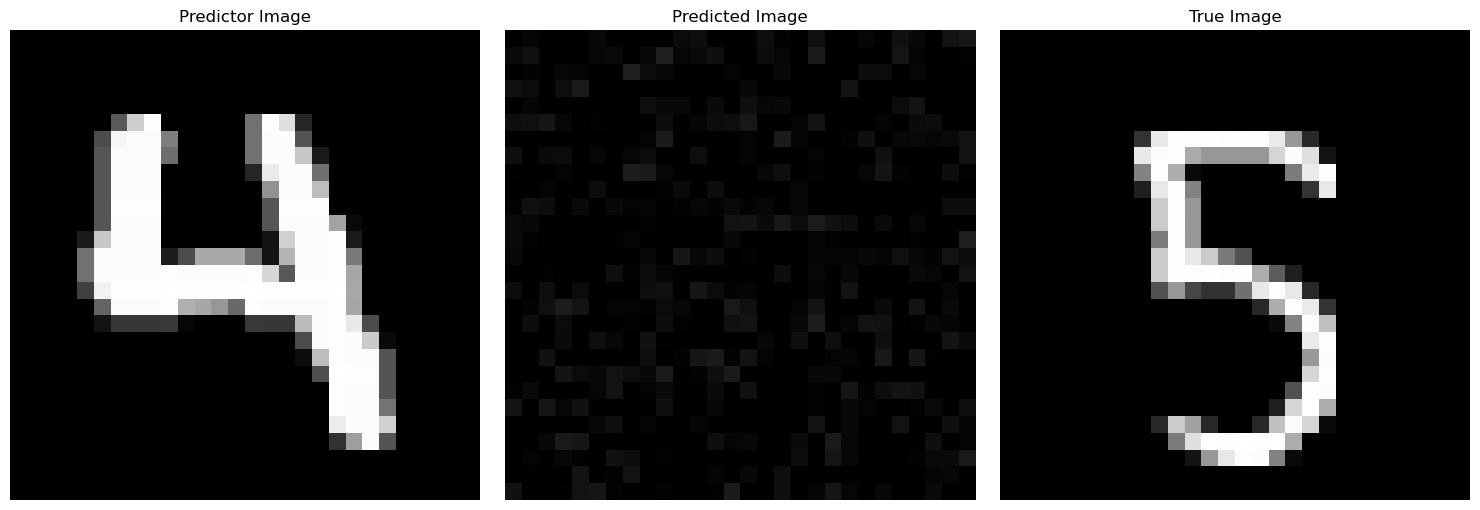

In [5]:
def plot_num2num_prediction(X, y, pred):
    """
    X, y, and pred are all numpy arrays of dimension (28, 28)
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(X.squeeze(), cmap="gray", vmin = 0., vmax = 1.)
    axes[0].set_title(f"Predictor Image")
    axes[0].axis("off")
    axes[1].imshow(pred.squeeze(), cmap="gray", vmin = 0., vmax = 1.)
    axes[1].set_title(f"Predicted Image")
    axes[1].axis("off")
    axes[2].imshow(y.squeeze(), cmap="gray", vmin = 0., vmax = 1.)
    axes[2].set_title(f"True Image")
    axes[2].axis("off")
    plt.tight_layout()
    plt.show()

#select a random sample from our test dataset
rand_test_idx = np.random.randint(len(data_module.test_ds))
i = rand_test_idx

#index test Dataset to get predictor (X) and target (y)
X, y = data_module.test_ds[i]
X_gpu = torch.from_numpy(X).to(device) #put the data onto the gpu

#make a prediction without keeping track of the gradient
with torch.no_grad():
    pred = model(X_gpu)
    pred = pred.cpu().numpy()

#plot predictions
plot_num2num_prediction(X, y, pred) #ok, there's room for improvement!

## The Training Loop
... is gone! Just call fit() on the trainer.

In [6]:
#call fit and PyTorch Lightning does the rest
trainer.fit(model, datamodule=data_module)

You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
C:\Users\nimzo\miniconda3\envs\pytorch_tutorial\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\nimzo\Documents\PyTorch Tutorial\git_version\models\MNIST_num2num\model_checkpoints\dense_nn_2HL_Lightning exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params | Mode
--------------------------------------------------------
0 | loss_function     | MSELoss    | 0      | eval
1 | flatten           | Flatten    | 0      | eval
2 | linear_relu_stack | Sequential | 1.1 M  | eval
----------------------------------------

Avg test loss: 0.11209137737751007|██████████████████████████████████████████████████████| 2/2 [00:00<00:00, 49.45it/s]
                                                                                                                       

C:\Users\nimzo\miniconda3\envs\pytorch_tutorial\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
C:\Users\nimzo\miniconda3\envs\pytorch_tutorial\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
C:\Users\nimzo\miniconda3\envs\pytorch_tutorial\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 0: 100%|███████████████████████████████████████████████████████████| 1563/1563 [00:38<00:00, 40.80it/s, v_num=10]
idation: |                                                                                    | 0/? [00:00<?, ?it/s]
idation DataLoader 0:  96%|████████████████████████████████████████████████████▋  | 300/313 [00:07<00:00, 41.80it/s]
Avg test loss: 0.055003754794597626███████████████████████████████████████████████| 313/313 [00:07<00:00, 41.82it/s]

Epoch 1: 100%|███████████████████████████████████████████████████████████| 1563/1563 [00:37<00:00, 41.70it/s, v_num=10]
idation: |                                                                                    | 0/? [00:00<?, ?it/s]
idation DataLoader 0:  96%|████████████████████████████████████████████████████▋  | 300/313 [00:06<00:00, 44.53it/s]
Avg test loss: 0.054667383432388306███████████████████████████████████████████████| 313/313 [00:07<00:00, 44.65it/s]

Epoch 2: 100%|██████████████████████████████████████████

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|███████████████████████████████████████████████████████████| 1563/1563 [00:49<00:00, 31.34it/s, v_num=10]


## Model Performance After Training

Now when we feed the trained model a predictor image, it successfully creates an image of the next digit, abeit fuzzily. This has everything to do with the uncertainty in the problem. The digit mapping is *not* injective, that is, the same digit may be mapped to several different subsequent ones. Therefore, when asking the model to make a deterministic step to the next digit, it has to "hedge" against not knowing the particular form of the next digit.

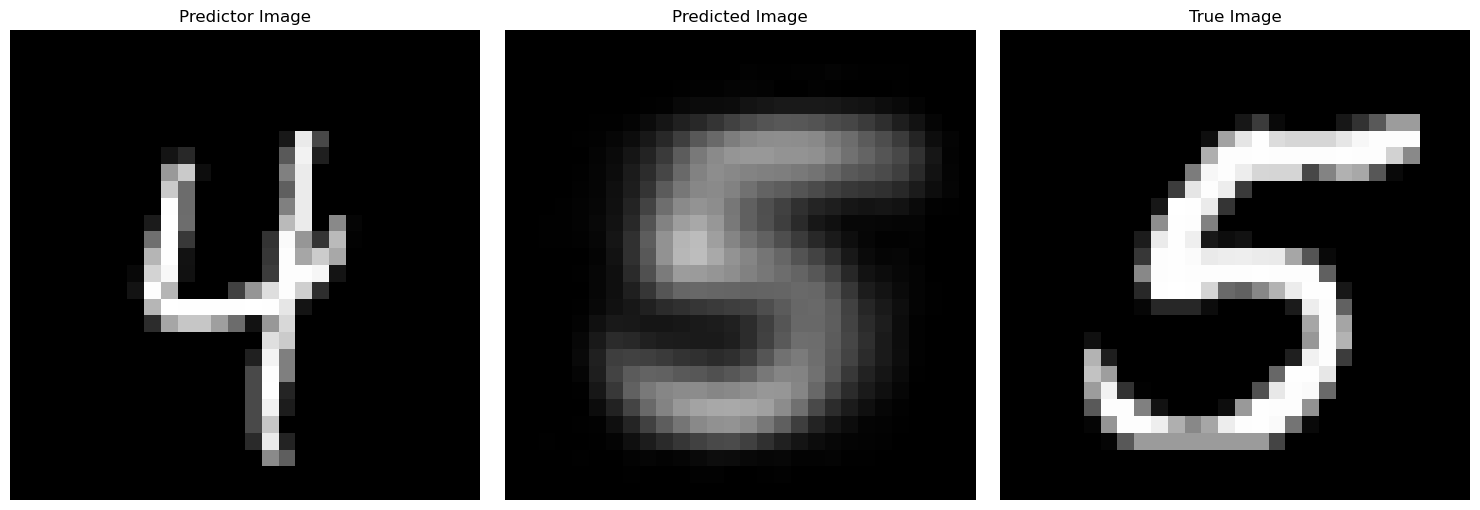

In [7]:
#make prediction plot as before, but with trained model
model.to(device)
rand_test_idx = np.random.randint(len(data_module.test_ds))
i = rand_test_idx
X, y = data_module.test_ds[i]
X_gpu = torch.from_numpy(X).to(device)
with torch.no_grad():
    pred = model(X_gpu)
    pred = pred.cpu().numpy()
plot_num2num_prediction(X, y, pred)

## Impact of Fuzziness on Autoregressive Rollout
With our simple, densely-connected NN architecture, the fuzziness causes instability in an autoregressive rollout (feeding model output back into itself). Particularly, the fuzzy 1s, 5s, and 3s are confused for 8s, and the model gets caught osillating between 9s and 0ish output.

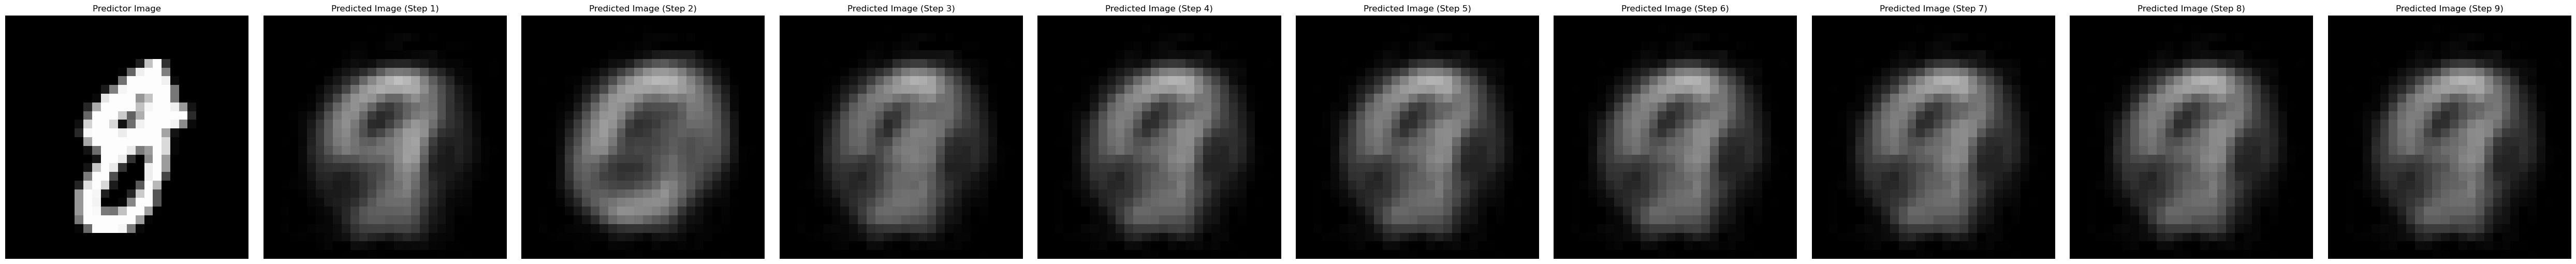

In [8]:
def plot_autoregressive_sequence(X, model, n_steps=3):
    """
    Plots the progression from the original predictor image through n autoregressive steps.
    :param X: numpy array - Original predictor image
    :param model: torch.nn.Module - Trained model for predictions
    :param n_steps: int - Number of autoregressive steps to take
    """
    device = next(model.parameters()).device 
    X_gpu = torch.from_numpy(X).to(device)

    predictions = [X] 
    current_input = X_gpu

    with torch.no_grad():
        for _ in range(n_steps):
            pred = model(current_input)  
            pred_np = pred.cpu().numpy()  
            predictions.append(pred_np) 
            current_input = torch.from_numpy(pred_np).to(device)  # Use prediction as new input

    # Create dynamic plotting layout
    n_cols = n_steps + 1  # Predictor + n steps + True image
    fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, 5))

    # Plot predictor image
    axes[0].imshow(X.squeeze(), cmap="gray", vmin=0., vmax=1.)
    axes[0].set_title("Predictor Image")
    axes[0].axis("off")

    # Plot each autoregressive step
    for i in range(1, n_steps + 1):
        axes[i].imshow(predictions[i].squeeze(), cmap="gray", vmin=0., vmax=1.)
        axes[i].set_title(f"Predicted Image (Step {i})")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Select a random test sample
rand_test_idx = np.random.randint(len(data_module.test_ds))
X, y = data_module.test_ds[rand_test_idx]

# Call function with n autoregressive steps
plot_autoregressive_sequence(X, model, n_steps=9)
